<a href="https://colab.research.google.com/github/envil/plda-pmf/blob/develop/Viet_Ta_BAY2_ReportForm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayensian Inference 2: Project Report

---



### Title: "Implement Probabilistic Matrix Factorization (PMF) on MoviesLens data"

### Name: "Viet Ta (299954)"


## Abstract
MovieLens's dataset consist of real anonymous data of user, movies, and ratings of users on the movies. The ratings data is no surprisingly incomplete.
In this project, Probabilistic Matrix Factorization (PMF) will be employed to discover latent variables of the dataset. From there will can generate the rating predictions and be able to predict the missing ratings.

## Introduction
### Problem statement
Recommending item/product to users is a very effective technique used by merchants/servers to increase their consumption. The feature is likely to be implemented by a recomendation system. In this project, we're interested in recommending movies to users based on the existing rating dataset.

### Dataset
User movie rating on MovieLens. Data can be found here: https://grouplens.org/datasets/movielens/1m/

There're approximately 1M anonymous ratings of 3900 movies and 6000 users.
We're mostly interested in the rating file. All ratings are contained in the file "ratings.dat" and are in the following format:

`UserID::MovieID::Rating::Timestamp`

* UserIDs range between 1 and 6040
* MovieIDs range between 1 and 3952
* Ratings are made on a 5-star scale (whole-star ratings only)
* Timestamp is represented in seconds since the epoch as returned by time(2)
* Each user has at least 20 ratings

### Hypothesis
Our hyphothesis is that there're many latent factors constructing the ratings, e.g.: genres, directors, length, user's nationality, etc. If we can deconstruct the ratings into its latent factors, we will then can approximate the complete ratings by multimplying the component matrices to get the ratings tables.
### Challenges
The biggest challenge for the recommendation systems are to cope with extreamly sparse data and high dimensions. The sparseness will lead to underflow floating point problem. The high dimensions will makes it very challenging to compute the results.
### Technique
#### Probabilistic Matrix Factorization
Matrix factorization is a common technique to reduce dimension of datasets, or in other words, discover latent variables underlying them.

Intuitively, a rating prediction is a dot product of the feature vectors corresponding to the movie and user.

However, the traditional matrix factorization techniques are usually limited in some ways, i.e cannot handle sparse matrices, computation time grow dramaticly with the number of dimensions.

Probabilistic Matrix Factorization is a simple probabilistic influenced model with Gaussian observation. More detailed explanation of PMF can be found on https://dl.acm.org/citation.cfm?id=2981720

The advantages of PMF is that it can deal with sparse data, and the computational time grow linearly with the data.

#### Variational Inference
Variational Inference (VI) is a technique of approximating the posterior distribution, which can produce comparable accuracy to Gibbs sampling but with greater speed.

In this project, I use VI to optimize the PMF by approximate the posterior distribution of the latent variables. More on this here: https://www.cs.princeton.edu/courses/archive/fall11/cos597C/lectures/variational-inference-i.pdf

### Programming Language & Libraries
- Language used: Python
- Libraries:
 - SciPy: free and open-source Python library used for scientific computing and technical computing. This includes NumPy and pandas: two data library.
 - TensorFlow: an open-source machine learning libabry which provides tools for a wide range of tasks.
 - TensforFlow Probability: an extension on TensorFlow library, which can be used to build combined probabilistic and deep learning models.
 - matplotlib: Python ploting library.
 
### Goal after finishing the project
* Build a working model.
* Increase knowledge on Bayesian Inference.

## Methods

In [0]:
# setup
!pip install PyDrive

### Accquiring Data & Visualization
In this step I simply get the data from Google Drive and read the data.
After that, I draw the rating matrix as an image. 

[[5. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [3. 0. 0. ... 0. 0. 0.]]


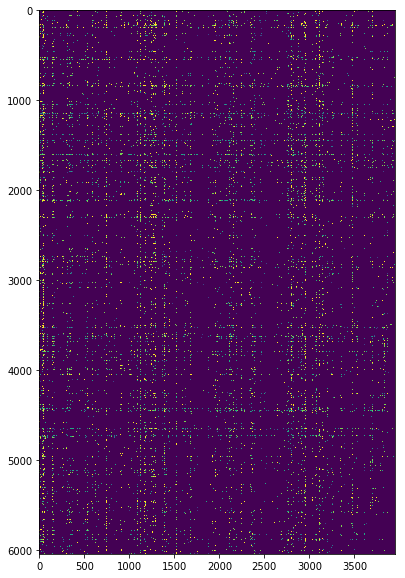

In [72]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt

from tensorflow_probability import edward2 as ed
tfd = tfp.distributions

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

N = 6040  # number of users
M = 3952  # number of movies
D = 10  # Latent factors
stddv_datapoints = 0.2

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
# 2. Load a file by ID and print its contents.
downloaded = drive.CreateFile({'id': "1VsenGA-cV1ZIHh4ot9gufBKu-gnXZIf6"})
downloaded.GetContentFile('ratings.dat')


def read_data():
    data = np.zeros((N, M))
    f = open("ratings.dat", "r")
    lines = f.readlines()

    for line in lines:
        user, movie, rating, *_ = list(map(int, line.split("::")))
        data[user - 1, movie - 1] = rating

    return data


data = read_data()
print(data)

plt.figure(figsize=(20,10))
plt.imshow(data, vmin=np.min(data), vmax=np.max(data))
plt.show()

By looking with eyes, we can see that the matrix is sparse, where most values are zeros.
### Model
Here we're using the Edward2 library in TPF to build the model, with $X=W*Z$. We then can obtain the log joint probability function by calling the `ed.make_log_join_fn()`

In [0]:
def probabilistic_matrix_factorization(data_dim, latent_dim, num_datapoints, stddv_datapoints):  # (unmodeled) data
    w = ed.Normal(loc=tf.zeros([data_dim, latent_dim]),
                  scale=tf.ones([data_dim, latent_dim]),
                  name="w")  # parameter
    z = ed.Normal(loc=tf.zeros([latent_dim, num_datapoints]),
                  scale=tf.ones([latent_dim, num_datapoints]),
                  name="z")  # parameter
    x = ed.Normal(loc=tf.matmul(w, z),
                  scale=stddv_datapoints * tf.ones([data_dim, num_datapoints]),
                  name="x") # (modeled) data
    return x, (w, z)


log_joint = ed.make_log_joint_fn(probabilistic_matrix_factorization)

### Inference process
After having the `log_joint`, we can then use VI to optimize the model. Our goal is to find the distribution $q(z)$, which mean to maximize the ELBO.

In [0]:
tf.reset_default_graph()


def variational_model(qw_mean, qw_stddv, qz_mean, qz_stddv):
    qw = ed.Normal(loc=qw_mean, scale=qw_stddv, name="qw")
    qz = ed.Normal(loc=qz_mean, scale=qz_stddv, name="qz")
    return qw, qz


def target(w, z):
    """Unnormalized target density as a function of the parameters."""
    return log_joint(data_dim=N,
                     latent_dim=D,
                     num_datapoints=M,
                     stddv_datapoints=stddv_datapoints,
                     w=w, z=z, x=data)


log_q = ed.make_log_joint_fn(variational_model)


def target_q(qw, qz):
    return log_q(qw_mean=qw_mean, qw_stddv=qw_stddv,
                 qz_mean=qz_mean, qz_stddv=qz_stddv,
                 qw=qw, qz=qz)


qw_mean = tf.Variable(np.ones([N, D]), dtype=tf.float32)
qz_mean = tf.Variable(np.ones([D, M]), dtype=tf.float32)
qw_stddv = tf.nn.softplus(tf.Variable(np.ones([N, D]), dtype=tf.float32))
qz_stddv = tf.nn.softplus(tf.Variable(np.ones([D, M]), dtype=tf.float32))

qw, qz = variational_model(qw_mean=qw_mean, qw_stddv=qw_stddv,
                           qz_mean=qz_mean, qz_stddv=qz_stddv)

energy = target(qw, qz)
entropy = -target_q(qw, qz)

elbo = energy + entropy

optimizer = tf.train.AdamOptimizer(learning_rate=0.05)
train = optimizer.minimize(-elbo)

init = tf.global_variables_initializer()

t = []

num_epochs = 500

with tf.Session() as sess:
    sess.run(init)

    for i in range(num_epochs):
        sess.run(train)
        if i % 5 == 0:
            t.append(sess.run([elbo]))

    w_mean_inferred = sess.run(qw_mean)
    w_stddv_inferred = sess.run(qw_stddv)
    z_mean_inferred = sess.run(qz_mean)
    z_stddv_inferred = sess.run(qz_stddv)


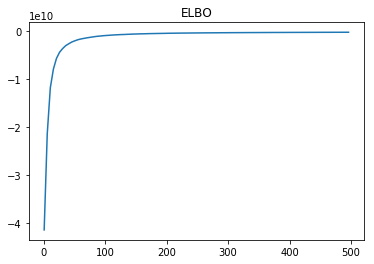

[-208992430.0]


In [0]:
# print("Inferred axes:")
# print(w_mean_inferred)
# print("Standard Deviation:")
# print(w_stddv_inferred)

plt.plot(range(1, num_epochs, 5), t)
plt.title('ELBO')
plt.show()
print(t[-1])

We can see that the model has converged, the ELBO has been maximized.

Now let's see how the predictions look like.

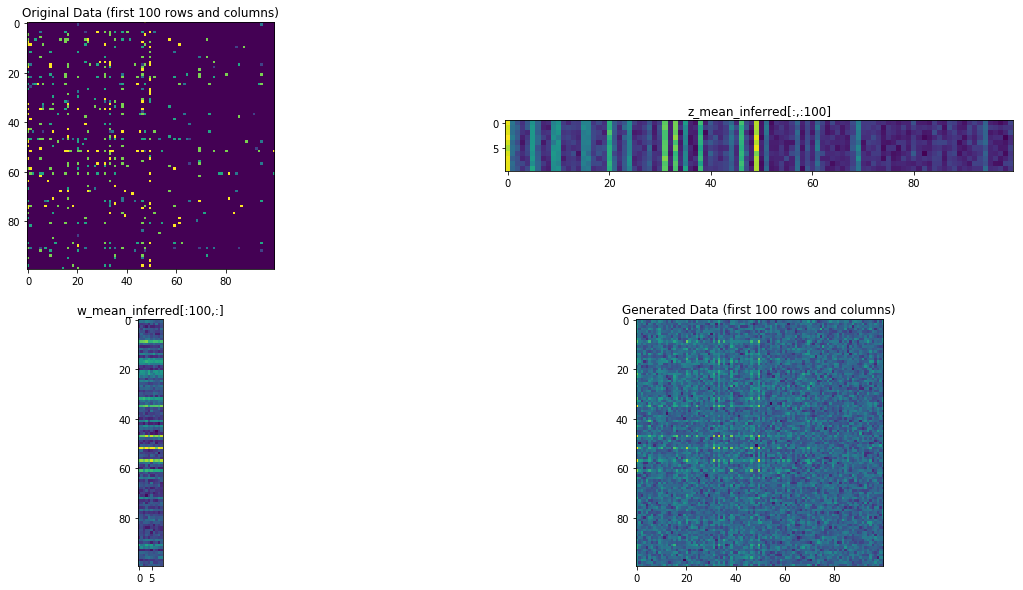

In [0]:
with ed.interception(ed.make_value_setter(w=w_mean_inferred,
                                          z=z_mean_inferred)):
    generate = probabilistic_matrix_factorization(
        data_dim=N, latent_dim=D,
        num_datapoints=M, stddv_datapoints=stddv_datapoints)

with tf.Session() as sess:
    x_generated, _ = sess.run(generate)


plt.figure(figsize=(20,10))
plt.subplot(221)
plt.imshow(data[:100, :100], vmin=np.min(data[:100, :100]), vmax=np.max(data[:100, :100]))
plt.title('Original Data (first 100 rows and columns)')

plt.subplot(224)
plt.imshow(x_generated[:100, :100], vmin=np.min(x_generated[:100, :100]), vmax=np.max(x_generated[:100, :100]))
plt.title('Generated Data (first 100 rows and columns)')

plt.subplot(223)
plt.imshow(w_mean_inferred[:100,:], vmin=np.min(w_mean_inferred[:100,:]), vmax=np.max(w_mean_inferred[:100,:]))
plt.title('w_mean_inferred[:100,:]')

plt.subplot(222)
plt.imshow(z_mean_inferred[:,:100], vmin=np.min(z_mean_inferred[:,:100]), vmax=np.max(z_mean_inferred[:,:100]))
plt.title('z_mean_inferred[:,:100]')
plt.show()

# Results
We can see that the generated data shares some prominent rows and columns with the original data, and other newly generated data in addition, which makes sense.

By taking each row and sort them, we can suggest the movies that the user will likely to rate with highest star.

## Improvement
Overall, the result is good, but we can improve the model by applying some constrains to the model. For example, we can force the rated data to be keeping the same, this's called Constrained PMF. I also have some idea to implement Non-negative version if this PMF to see if it's better, or if it could produce a more intuitive result

## Conclusion
By applying Probabilistic Matrix Factorization together with Variantion Inference, we can generate missing rating from the original incomplete rating data. Generally, the result was good, yet there are some thing that can be improved.

I have achieved my goals for this project.

## Reference
1. https://dl.acm.org/citation.cfm?id=2981720
2. https://www.cs.princeton.edu/courses/archive/fall11/cos597C/lectures/variational-inference-i.pdf